# Pruned Exact Linear Time (PELT) change point detection on BERT embeddings

Change point detection library:
https://centre-borelli.github.io/ruptures-docs/examples/text-segmentation

HuggingFace pretrained Bert Model:
https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

## Library imports

In [4]:
from pathlib import Path
import numpy as np
import ruptures as rpt
from ruptures.base import BaseCost
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

C:\Users\erick\.conda\envs\thesis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\erick\.conda\envs\thesis\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\erick\.conda\envs\thesis\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\erick\.conda\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def mean_pooling(model_output, attention_mask):
    #Mean Pooling - Take attention mask into account for correct averaging
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def draw_square_on_ax(start, end, ax, linewidth=0.8):
    """Draw a square on the given ax object."""
    ax.vlines(
        x=[start - 0.5, end - 0.5],
        ymin=start - 0.5,
        ymax=end - 0.5,
        linewidth=linewidth,
    )
    ax.hlines(
        y=[start - 0.5, end - 0.5],
        xmin=start - 0.5,
        xmax=end - 0.5,
        linewidth=linewidth,
    )
    return ax

class CosineCost(BaseCost):
    """Cost derived from the cosine similarity."""

    # The 2 following attributes must be specified for compatibility.
    model = "custom_cosine"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        self.gram = cosine_similarity(signal, dense_output=False)
        return self

    def error(self, start, end) -> float:
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment
        Returns:
            segment cost
        Raises:
            NotEnoughPoints: when the segment is too short (less than `min_size` samples).
        """
        if end - start < self.min_size:
            raise NotEnoughPoints
        sub_gram = self.gram[start:end, start:end]
        val = sub_gram.diagonal().sum()
        val -= sub_gram.sum() / (end - start)
        return val

## Import pretrained BERT model

In [6]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

## Data description

In [7]:
# Loading the text
filepath = Path("text-segmentation-data.txt")
original_text = filepath.read_text().split("\n")
TRUE_BKPS = [11, 20, 30, 40, 49, 59, 69, 80, 90, 99]  # read from the data description

print(f"There are {len(original_text)} sentences, from {len(TRUE_BKPS)} documents.")

There are 99 sentences, from 10 documents.


## Data examples

In [8]:
# print 5 sentences from the original text
start, end = 9, 14
for (line_number, sentence) in enumerate(original_text[start:end], start=start + 1):
    sentence = sentence.strip("\n")
    print(f"{line_number:>2}: {sentence}")

10: That could be easily done , but there is little reason in it .
11: It would come down to saying that Fromm paints with a broad brush , and that , after all , is not a conclusion one must work toward but an impression he has from the outset .
12: the effect of the digitalis glycosides is inhibited by a high concentration of potassium in the incubation medium and is enhanced by the absence of potassium ( Wolff , 1960 ) .
13: B. Organification of iodine The precise mechanism for organification of iodine in the thyroid is not as yet completely understood .
14: However , the formation of organically bound iodine , mainly mono-iodotyrosine , can be accomplished in cell-free systems .


## Create text embeddings

In [9]:
# Tokenize sentences
encoded_input = tokenizer(original_text, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

## Declare PELT change point detection model

In [10]:
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, custom_cost=CosineCost(), min_size=1, jump=1).fit(sentence_embeddings)

### Penalty paramater at 1

In [11]:
print(algo.predict(pen=1))

[3, 7, 11, 20, 30, 40, 49, 53, 59, 66, 69, 71, 78, 80, 85, 88, 90, 92, 99]


### Penalty paramater at 10

In [18]:
print(algo.predict(pen=10))

[99]


### Penalty paramater at 2

In [19]:
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, custom_cost=CosineCost(), min_size=1, jump=1).fit(sentence_embeddings)
predicted_bkps = algo.predict(pen=2)
print(len(predicted_bkps),predicted_bkps)

10 [11, 20, 30, 40, 49, 59, 69, 80, 90, 99]


### PELT change points with penalty parameter at 2 result in predicted break points matching identically to ground truth break points

In [20]:
true_segment_list = rpt.utils.pairwise([0] + TRUE_BKPS)
predicted_segment_list = rpt.utils.pairwise([0] + predicted_bkps)

for (n_paragraph, (true_segment, predicted_segment)) in enumerate(
    zip(true_segment_list, predicted_segment_list), start=1
):
    print(f"Paragraph n°{n_paragraph:02d}")
    start_true, end_true = true_segment
    start_pred, end_pred = predicted_segment

    start = min(start_true, start_pred)
    end = max(end_true, end_pred)
    msg = " ".join(
        f"{ind+1:02d}" if (start_true <= ind < end_true) else "  "
        for ind in range(start, end)
    )
    print(f"(true)\t{msg}")
    msg = " ".join(
        f"{ind+1:02d}" if (start_pred <= ind < end_pred) else "  "
        for ind in range(start, end)
    )
    print(f"(pred)\t{msg}")
    print()

Paragraph n°01
(true)	01 02 03 04 05 06 07 08 09 10 11
(pred)	01 02 03 04 05 06 07 08 09 10 11

Paragraph n°02
(true)	12 13 14 15 16 17 18 19 20
(pred)	12 13 14 15 16 17 18 19 20

Paragraph n°03
(true)	21 22 23 24 25 26 27 28 29 30
(pred)	21 22 23 24 25 26 27 28 29 30

Paragraph n°04
(true)	31 32 33 34 35 36 37 38 39 40
(pred)	31 32 33 34 35 36 37 38 39 40

Paragraph n°05
(true)	41 42 43 44 45 46 47 48 49
(pred)	41 42 43 44 45 46 47 48 49

Paragraph n°06
(true)	50 51 52 53 54 55 56 57 58 59
(pred)	50 51 52 53 54 55 56 57 58 59

Paragraph n°07
(true)	60 61 62 63 64 65 66 67 68 69
(pred)	60 61 62 63 64 65 66 67 68 69

Paragraph n°08
(true)	70 71 72 73 74 75 76 77 78 79 80
(pred)	70 71 72 73 74 75 76 77 78 79 80

Paragraph n°09
(true)	81 82 83 84 85 86 87 88 89 90
(pred)	81 82 83 84 85 86 87 88 89 90

Paragraph n°10
(true)	91 92 93 94 95 96 97 98 99
(pred)	91 92 93 94 95 96 97 98 99



## Show the Gram matrix

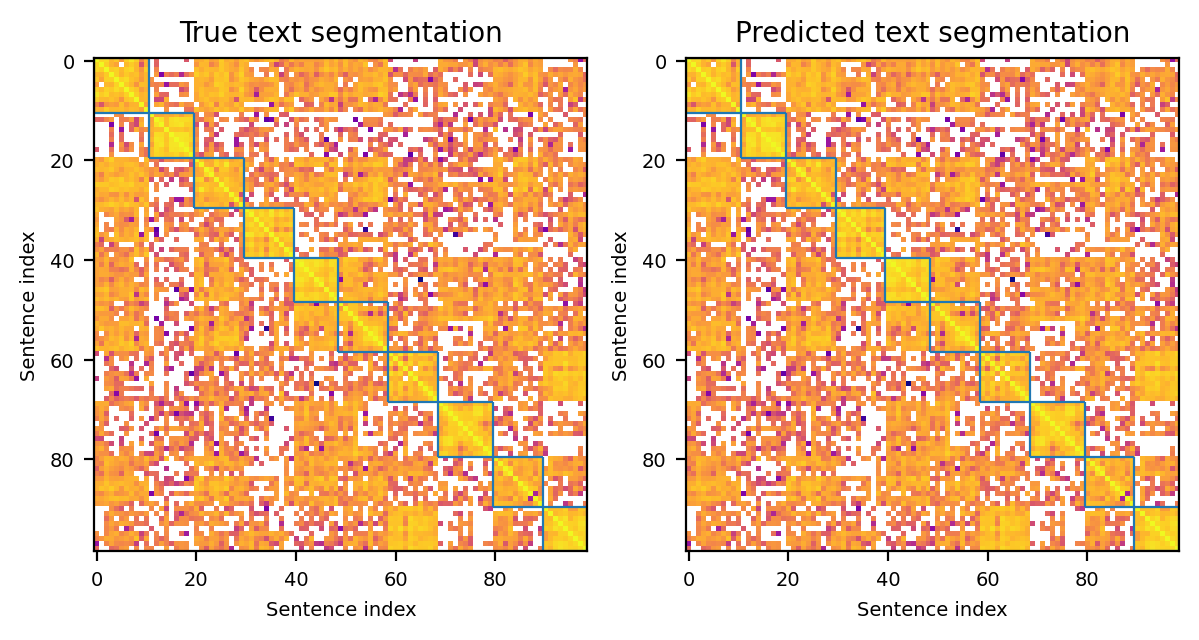

In [21]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(7, 5), dpi=200)

# plot config
title_fontsize = 10
label_fontsize = 7
title_list = ["True text segmentation", "Predicted text segmentation"]

for (ax, title, bkps) in zip(ax_arr, title_list, [TRUE_BKPS, predicted_bkps]):
    # plot gram matrix
    ax.imshow(algo.cost.gram, cmap=cm.plasma, norm=LogNorm())
    # add text segmentation
    for (start, end) in rpt.utils.pairwise([0] + bkps):
        draw_square_on_ax(start=start, end=end, ax=ax)
    # add labels and title
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("Sentence index", fontsize=label_fontsize)
    ax.set_ylabel("Sentence index", fontsize=label_fontsize)
    ax.tick_params(axis="both", which="major", labelsize=label_fontsize)